In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1OJWRb5XakWPL_rZFYDS588ktwXViMYP7'})
download.GetContentFile('dataset.pkl')

In [0]:
import pickle
import torch

with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
X_train = data['train']
X_val = data['test']

In [0]:
import torch

trainLoader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
valLoader = torch.utils.data.DataLoader(X_val, batch_size=128, shuffle=True)

In [0]:
from torch import nn
from torch.nn import functional as F


class Block(nn.Module):

    def __init__(self, in_dim):
        super().__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_dim, in_dim * 2, kernel_size=3, padding=1),
                                  nn.ReLU(),
                                  nn.Conv2d(in_dim * 2, in_dim, kernel_size=3, padding=1),
                                  nn.ReLU())

    def forward(self, x):
        return self.conv(x) + x


class Resnet(nn.Module):
  
    def __init__(self, in_dim, num_blocks=8):
        super().__init__()

        self.conv1 = nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1)
        self.cnn = nn.Sequential(*[Block(in_dim) for i in range(num_blocks)])
        self.conv2 = nn.Conv2d(in_dim, in_dim * 2, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.cnn(x)
        x = F.relu(self.conv2(x))
        return x

In [0]:
class AffineCoupling(nn.Module):
    
    def __init__(self, in_dim):
        super().__init__()
        
        self.resnet = Resnet(in_dim)
    
    def forward(self, x, mask):
        z1 = x * mask
        log_s, t = torch.chunk(self.resnet(x * mask), 2, dim=1)
        log_s = F.tanh(log_s)
        z = z1 + (1 - mask) * (log_s.exp() * x + t)
        log_det = log_s.sum(dim=1)
        return z, log_det

    def backward(self, z, mask):
        x1 = z * mask
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        log_s = F.tanh(log_s)
        x = x1 + (1 - mask) * (z * torch.exp(-log_s) - t)
        return x

In [0]:
class AffineConstantFlow(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True))
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True))
        
    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        s = F.tanh(s).exp()
        z = x * s + t
        log_det = torch.sum(s, dim=1)
        return z, log_det, s.detach()
    
    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        return x

In [0]:
class ActNorm(AffineConstantFlow):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_dep_init_done = False
    
    def forward(self, x):
        if not self.data_dep_init_done:
            self.s.data = (-torch.log(x.std(dim=0, keepdim=True))).detach()
            self.t.data = (-(x * torch.exp(self.s)).mean(dim=0, keepdim=True)).detach()
            self.data_dep_init_done = True
        return super().forward(x)

In [0]:
import numpy as np
import torch.nn.functional as F

class CelebA(nn.Module):
    
    def __init__(self, in_dim, channels=32):
        super().__init__()
        
        self.block_sizes = [4, 3, 3, 3, 3]
        self.block_channels = [in_dim, in_dim * 4, in_dim * 4, in_dim * 16, in_dim * 16]
        self.actNorm = ActNorm(32)
        self.couplings = nn.ModuleList([nn.ModuleList([AffineCoupling(ch) for i in range(size)])
                                       for size, ch in zip(self.block_sizes, self.block_channels)])

    def build_mask(self, size):
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(1. + mask, 2)
        mask = mask.reshape(-1, 1, size, size)
        return torch.tensor(mask.astype('float32'))

    def checkerboard_split(self, x):
        return self.build_mask(x.shape[2]).cuda()

    def inverse_checkerboard_split(self, x):
        return x

    def squeeze(self, x):
        return x.reshape(-1, 4 * x.shape[1], x.shape[2] // 2, x.shape[3] // 2)
  
    def unsqueeze(self, x):
        return x.reshape(-1, x.shape[1] // 4, x.shape[2] * 2, x.shape[3] * 2)

    def channel_split(self, x):
        mask = torch.zeros((1, x.shape[1], x.shape[2], x.shape[3])).cuda()
        mask[:, :mask.shape[1] // 2, :, :] = 1
        return mask

    def inverse_channel_split(self, x):
        return x

    def forward(self, x):
        splits = [self.checkerboard_split, self.channel_split]
        inverts = [lambda x: self.squeeze(self.inverse_checkerboard_split(x)), self.inverse_channel_split]
        
        x, log_det, s = self.actNorm(x)
        log_det = log_det.mean()

        for i, (coupling, num_blocks) in enumerate(zip(self.couplings, self.block_sizes)):
            mask = splits[i % 2](x) 
            for j in range(num_blocks):
                x, loss = coupling[j](x, mask)
                mask = 1 - mask
                log_det += loss.sum(1).mean()
            x = inverts[i % 2](x)

        return x, log_det, s.mean()
    
    def reverse(self, x):
        x = self.squeeze(self.squeeze(x)) 
        splits = [self.checkerboard_split, self.channel_split]
        inverts = [self.inverse_checkerboard_split, lambda x: self.unsqueeze(self.inverse_channel_split(x))]
        
        for i, (coupling, num_blocks) in enumerate(zip(reversed(self.couplings), reversed(self.block_sizes))):
            mask = splits[i % 2](x) 
            for j in range(num_blocks):
                x = coupling[j].backward(x, mask)
                mask = 1 - mask
            x = inverts[i % 2](x)
        
        x = self.actNorm.backward(x)
        return x

In [0]:
from torch import optim

def train(model, data_loader, val_loader, epochs=10, lr=5e-4, device='cuda'):

    opt = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    val_loss = []
    
    prior = torch.distributions.Normal(torch.zeros(1).to(device), torch.ones(1).to(device)) 

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            batch = batch.transpose(1, 3).cuda().float()
            x, log_det, s = model(batch)
            
            kl = -prior.log_prob(x).sum(1).mean()
            loss = (kl - log_det) / s
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()
            train_loss.append(float(loss) / 2)

            if (j + 1) % 20 == 0:
                with torch.no_grad():
                    for val_batch in val_loader:
                        val_batch = val_batch.transpose(1, 3).cuda().float()
                        x, log_det, s = model(val_batch)
            
                        kl = -prior.log_prob(x).sum(1).mean()
                        loss = (kl - log_det) /s
                        val_loss.append(float(loss) / 2)

    return train_loss, val_loss

In [0]:
model = CelebA(3).cuda()

In [335]:
train_loss, val_loss = train(model, trainLoader, valLoader, 100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

In [0]:
import numpy as np


def plot(y, title):
    x = np.arange(len(y))
    plt.plot(x, y)
    plt.title(title)
    plt.show()

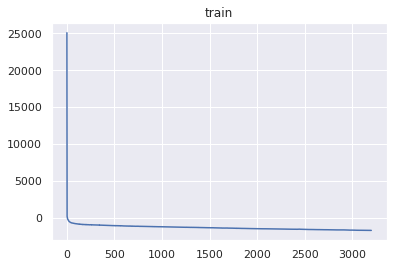

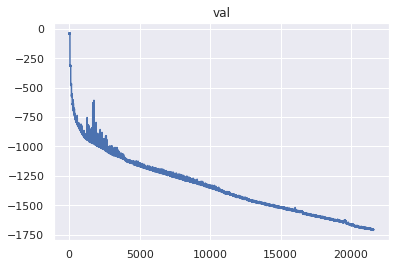

In [336]:
plot(train_loss, 'train')
plot(val_loss, 'val')

In [0]:
def sample(model, samples=12):
    with torch.no_grad():
      z = torch.randn([samples, 3, 32, 32]).cuda()
      images = model.reverse(z)
    return images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


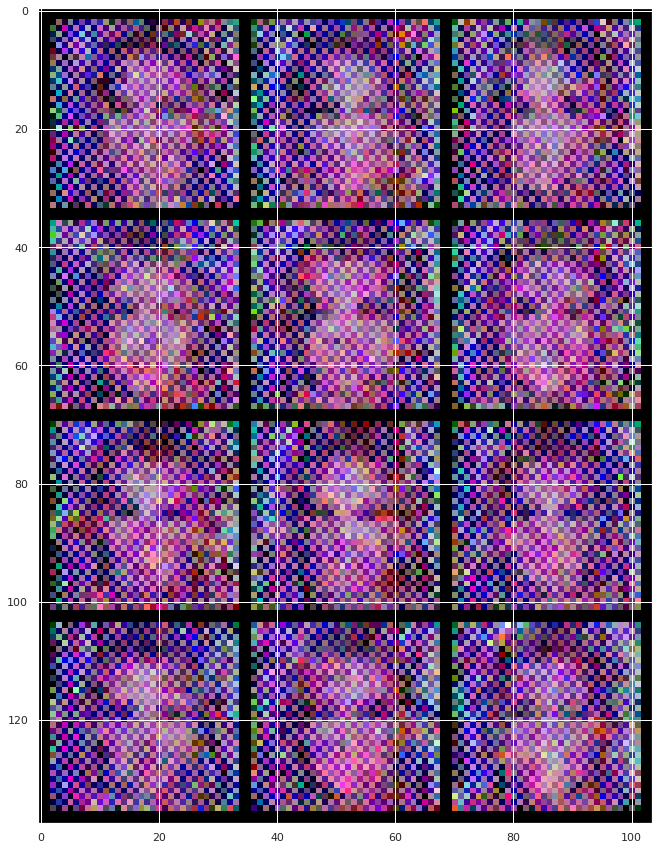

In [349]:
samples = sample(model)

image = torchvision.utils.make_grid(samples, nrow=4).permute(2, 1, 0).cpu().detach().numpy()
plt.figure(figsize=[15, 15])
plt.imshow(np.clip(image[:, :, [2, 0, 1]] / 4.5, 0, 1))

In [0]:
def show_interpolation(model, n=5, m=10):
    idx = np.arange(n)
    start = torch.from_numpy(X_train[idx]).cuda().transpose(1, 3).float()
    end = torch.from_numpy(X_train[idx + n]).cuda().transpose(1, 3).float()
    images = []
    with torch.no_grad():
        for i in range(n):
            (la, _, _), (lb, _, _) = model(start[i].unsqueeze(0)), model(end[i].unsqueeze(0))
            la = model.unsqueeze(model.unsqueeze(model.unsqueeze(la)))
            lb = model.unsqueeze(model.unsqueeze(model.unsqueeze(lb)))
            for coef in np.linspace(0, 1, m):
                image = model.reverse(la + (lb - la) * coef)
                images.append(image)
    image = torchvision.utils.make_grid(torch.cat(images), nrow=m).permute(2, 1, 0).cpu().numpy()
    plt.figure(figsize=[15, 15])
    plt.imshow(np.clip(image[:, :, [2, 0, 1]] / 4.5, 0, 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


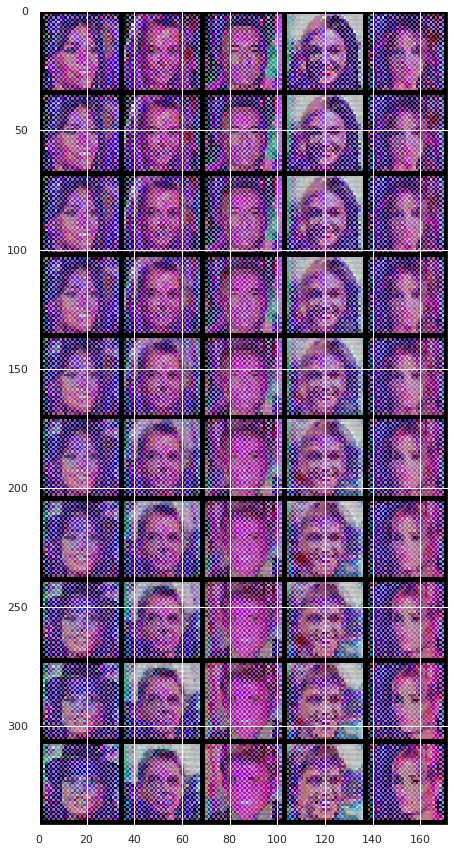

In [347]:
show_interpolation(model)